In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneGroupOut
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier

In [56]:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    """    df['Temp_slope'] = df['Temp_slope'].str.replace(r'(\d)(?=-\d)', r'\1e', regex=True)
    df['Temp_slope'] = df['Temp_slope'].str.replace(r'[^\d.e+-]', '', regex=True).astype(float)"""

    return df

In [57]:
"""SIGNAL_CATEGORIES = {
    'ECG_BVP': ['HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'],
    'EDA': ['EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_range', 'EDA_slope', 'scl_mean', 'scl_std', 'scr_mean', 'scr_std', 'corr_scl_t', 'scr_count', 'scr_amp', 'scr_sum', 'scr_area'],
    'EMG': ['EMG_mean', 'EMG_std', 'EMG_median', 'EMG_p10', 'EMG_p90', 'EMG_range', 'EMG_sum', 'EMG_f_peak', 'EMG_PSD_bands', 'EMG_peak_count', 'EMG_peak_amp_mean', 'EMG_peak_amp_std', 'EMG_peak_amp_sum', 'EMG_peak_amp_norm'],
    'RESP': ['Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std', 'Resp_E_mean', 'Resp_E_std', 'Resp_IE_ratio', 'Resp_range', 'Resp_insp_vol', 'Resp_rate', 'Resp_duration'],
    'TEMP': ['Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Temp_range', 'Temp_slope']
}"""


SIGNAL_CATEGORIES = {
    'ECG': ['HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'],
    'PPG': ['PPG_HR_mean', 'PPG_HR_std', 'PPG_RMSSD', 'PPG_SDNN', 'PPG_LF', 'PPG_HF', 'PPG_LF_HF', 'PPG_num_beats', 
            'PPG_RiseTime', 'PPG_DecayTime', 'PPG_PAV_mean', 'PPG_PAV_std', 'PPG_RI'],
    'EDA': ['EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_range', 'EDA_slope', 'scl_mean', 'scl_std', 
            'scr_mean', 'scr_std', 'corr_scl_t', 'scr_count', 'scr_amp', 'scr_sum', 'scr_area'],
    'RESP': ['Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std', 'Resp_E_mean', 'Resp_E_std', 'Resp_IE_ratio', 
             'Resp_range', 'Resp_insp_vol', 'Resp_rate', 'Resp_duration'],
}
random = 13577

In [58]:
def calculate_metrics(y_true, y_pred, stage):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Valor": [accuracy, precision, recall, f1],
        "Etapa": stage
    })
    
    print(f"{stage} Metrics")
    print(metrics_table)
    return metrics_table

In [59]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"{title} - Confusion Matrix")
    print(conf_mat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", xticklabels=set(y_true), yticklabels=set(y_true), fmt='g')
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas verdaderas")
    plt.title(f'Matriz de confusión - {title}')
    plt.show()

In [60]:
def train_and_evaluate_loso(X, y, subjects, model, param_grid, model_name, signal_name):
    logo = LeaveOneGroupOut()
    y_true_all = []
    y_pred_all = []

    all_metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

    for train_idx, test_idx in logo.split(X, y, groups=subjects):
        y_train_fold = y[train_idx]
        class_counts = Counter(y_train_fold)
        print(f"Distribución de clases en el fold: {class_counts}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        train_subjects = subjects.iloc[train_idx]

        # Normalización de los datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Leave-One-Group-Out interno para validación cruzada dentro del fold externo
        inner_logo = LeaveOneGroupOut()
        inner_cv = inner_logo.split(X_train_scaled, y_train, groups=train_subjects)

        # Grid search usando LOGO interno
        grid_search = GridSearchCV(model, param_grid, cv=inner_cv, n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name} (LOSO Fold)")
        best_params = grid_search.best_params_
        print(f"Best params for {model_name} in {signal_name}: {best_params}")

        all_metrics["accuracy"].append(metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0])
        all_metrics["precision"].append(metrics.loc[metrics["Métrica"] == "Precision", "Valor"].values[0])
        all_metrics["recall"].append(metrics.loc[metrics["Métrica"] == "Recall", "Valor"].values[0])
        all_metrics["f1_score"].append(metrics.loc[metrics["Métrica"] == "F1 Score", "Valor"].values[0])

        plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    final_metrics = {
        "accuracy": np.mean(all_metrics["accuracy"]),
        "precision": np.mean(all_metrics["precision"]),
        "recall": np.mean(all_metrics["recall"]),
        "f1_score": np.mean(all_metrics["f1_score"])
    }

    print(f'[{signal_name} - {model_name}] Final Metrics:')
    print(pd.DataFrame(final_metrics, index=["Valor"]).T)

    folds = range(1, len(all_metrics["accuracy"]) + 1)
    plt.figure(figsize=(10, 6))

    plt.plot(folds, all_metrics["accuracy"], label="Accuracy", marker='o')
    plt.plot(folds, all_metrics["precision"], label="Precision", marker='x')
    plt.plot(folds, all_metrics["recall"], label="Recall", marker='s')
    plt.plot(folds, all_metrics["f1_score"], label="F1 Score", marker='^')

    plt.xlabel("Fold")
    plt.ylabel("Metric Value")
    plt.title(f"Metrics per Fold - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return final_metrics

In [61]:
'''models = {
    "DecisionTree": (
        DecisionTreeClassifier(class_weight='balanced'),
        {"max_depth": [5, 10, 20, None]}
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight='balanced'),
        {"n_estimators": [50, 100, 200], "max_depth": [10, 20, None]}
    ),
    "AdaBoost": (
        AdaBoostClassifier(),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {"solver": ["svd", "lsqr", "eigen"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    )
}'''

'models = {\n    "DecisionTree": (\n        DecisionTreeClassifier(class_weight=\'balanced\'),\n        {"max_depth": [5, 10, 20, None]}\n    ),\n    "RandomForest": (\n        RandomForestClassifier(class_weight=\'balanced\'),\n        {"n_estimators": [50, 100, 200], "max_depth": [10, 20, None]}\n    ),\n    "AdaBoost": (\n        AdaBoostClassifier(),\n        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1]}\n    ),\n    "LDA": (\n        LinearDiscriminantAnalysis(),\n        {"solver": ["svd", "lsqr", "eigen"]}\n    ),\n    "KNN": (\n        KNeighborsClassifier(),\n        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}\n    )\n}'

In [62]:
models = {
    "RandomForest": (
    RandomForestClassifier(class_weight='balanced', random_state=random),
    {"n_estimators": [100, 200, 300],
     "max_depth": [None, 10, 20],
     "min_samples_split": [2, 5, 10]}
    ),
    """"DecisionTree": (
        DecisionTreeClassifier(class_weight='balanced'),
        {"max_depth": [5, 10, 15],
        "min_samples_split": [5, 10, 15], 
        "max_leaf_nodes": [10, 15, 20, 30, 40]}
    ),"""
    "AdaBoost": (
        AdaBoostClassifier(),
        {"n_estimators": [50, 100, 200, 300], 
        "learning_rate": [0.01, 0.1, 0.5, 1], 
        "base_estimator": [DecisionTreeClassifier(max_depth=1), 
                            DecisionTreeClassifier(max_depth=3)]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {"solver": ["svd", "lsqr", "eigen"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    )
}

In [63]:
#file = r'C:\Users\IALAB\Downloads\WESAD_TEST\features_30_025\features.csv'
file = r'features_30_075\features.csv'

results = {}

df = load_data(file)

In [64]:
for signal, features in tqdm({**SIGNAL_CATEGORIES, "ALL": df.columns.drop(['label', 'subject'])}.items(), desc="Training Models"):
    X = df[features] if signal != "ALL" else df.drop(columns=['label', 'subject'])
    y = df['label']
    subjects = df['subject']
    
    for model_name, (model, param_grid) in models.items():
        print(f'Training {model_name} model for {signal} using LOSO...')
        metrics = train_and_evaluate_loso(X, y, subjects, model, param_grid, model_name, signal)
        results[(signal, model_name)] = metrics

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), metrics in results.items():
    print(f'{signal} - {model_name}:')
    for metric_name, value in metrics.items():
        print(f'  {metric_name}: {value:.4f}')


Training Models:   0%|          | 0/5 [00:00<?, ?it/s]

Training RandomForest model for ECG using LOSO...
Distribución de clases en el fold: Counter({1: 19957, 2: 16140, 3: 12394})
Fitting 10 folds for each of 27 candidates, totalling 270 fits


Training Models:   0%|          | 0/5 [00:54<?, ?it/s]


KeyboardInterrupt: 

COMPLETE

In [ ]:
X_all = df.drop(columns=['label', 'subject'])  # Excluir la columna objetivo y el identificador de sujetos
y_all = df['label']
subjects_all = df['subject']

results = {}

In [ ]:
imputer = SimpleImputer(strategy="mean")  # Puedes probar "median" o "most_frequent"
X_all = pd.DataFrame(imputer.fit_transform(X_all), columns=X_all.columns)


undersampler = RandomUnderSampler(sampling_strategy={1: 38904}, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_all, y_all)
df_resampled = pd.DataFrame(X_resampled, columns=X_all.columns)
df_resampled['label'] = y_resampled
subjects_resampled = subjects_all.loc[df_resampled.index].reset_index(drop=True)

X_resampled = df_resampled.drop(columns=['label']).reset_index(drop=True)
y_resampled = df_resampled['label'].reset_index(drop=True)
subjects_resampled = subjects_resampled.reset_index(drop=True)


print("Distribución después de undersampling:", Counter(y_resampled))
# Entrenar con todas las señales combinadas

Distribución después de undersampling: Counter({1: 38904, 2: 38904, 3: 21459})


Training with ALL signals:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Distribución de clases en el fold: Counter({2: 36444, 1: 36356, 3: 20131})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.388889  ALL - DecisionTree (LOSO Fold)
1  Precision  0.158492  ALL - DecisionTree (LOSO Fold)
2     Recall  0.388889  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.823056  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 15}
ALL - DecisionTree - Confusion Matrix
[[2464    1   83]
 [2460    0    0]
 [1328    0    0]]


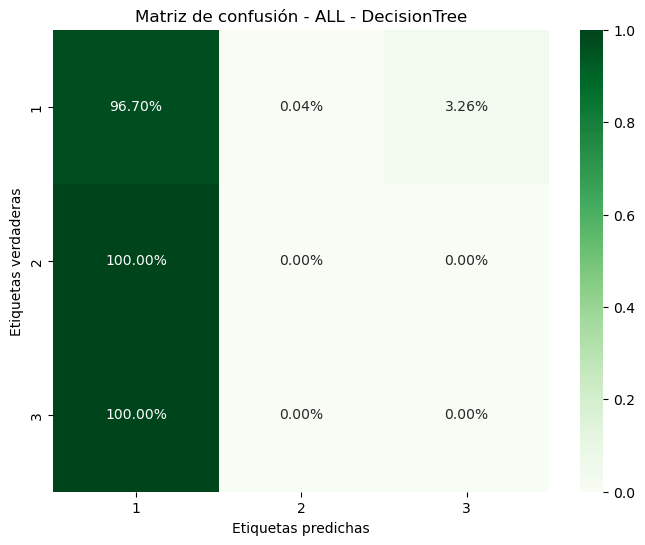

Distribución de clases en el fold: Counter({1: 36389, 2: 36344, 3: 20079})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.598296  ALL - DecisionTree (LOSO Fold)
1  Precision  0.679112  ALL - DecisionTree (LOSO Fold)
2     Recall  0.598296  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.611454  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 15, 'max_leaf_nodes': 30, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[1760   10  745]
 [ 962 1498  100]
 [ 776    0  604]]


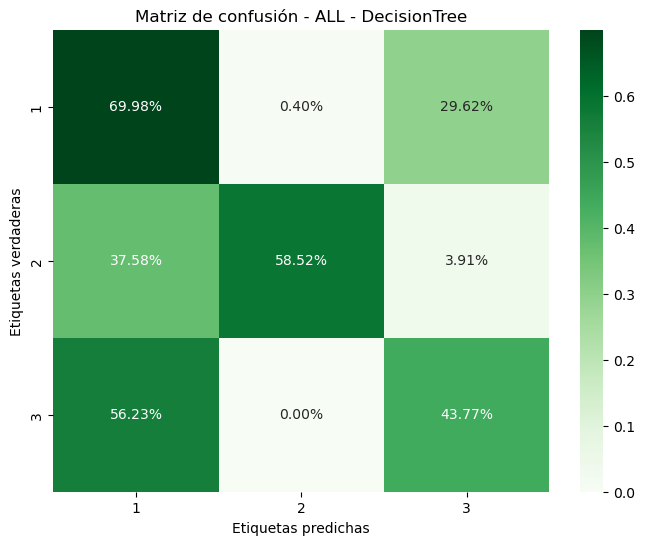

Distribución de clases en el fold: Counter({2: 36484, 1: 36379, 3: 19971})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.363439  ALL - DecisionTree (LOSO Fold)
1  Precision  0.589155  ALL - DecisionTree (LOSO Fold)
2     Recall  0.363439  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.263301  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 15}
ALL - DecisionTree - Confusion Matrix
[[ 889    0 1636]
 [2199    0  221]
 [  39    0 1449]]


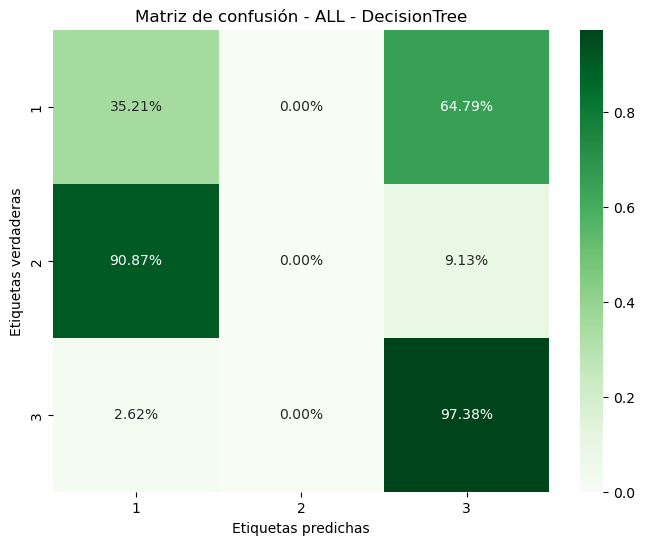

Distribución de clases en el fold: Counter({2: 36444, 1: 36319, 3: 19963})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.758905  ALL - DecisionTree (LOSO Fold)
1  Precision  0.862883  ALL - DecisionTree (LOSO Fold)
2     Recall  0.758905  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.767364  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[2171   84  330]
 [   0 1297 1163]
 [   0    0 1496]]


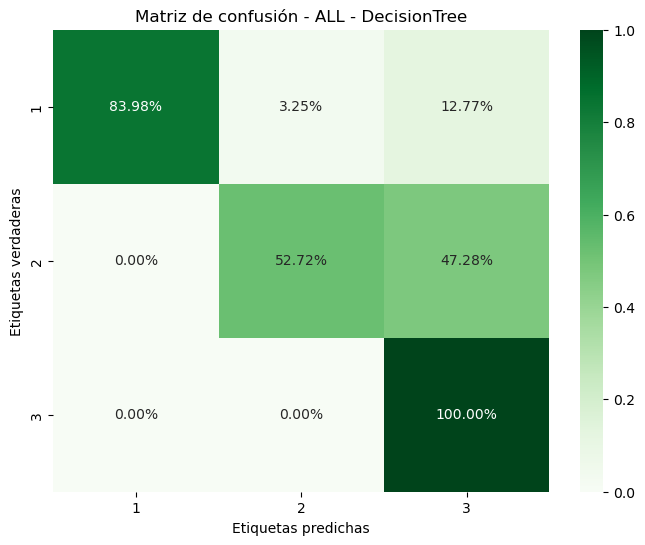

Distribución de clases en el fold: Counter({2: 36304, 1: 36301, 3: 20091})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.611627  ALL - DecisionTree (LOSO Fold)
1  Precision  0.662751  ALL - DecisionTree (LOSO Fold)
2     Recall  0.611627  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.599876  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 5, 'max_leaf_nodes': 30, 'min_samples_split': 15}
ALL - DecisionTree - Confusion Matrix
[[1690  143  770]
 [1518 1061   21]
 [  21   79 1268]]


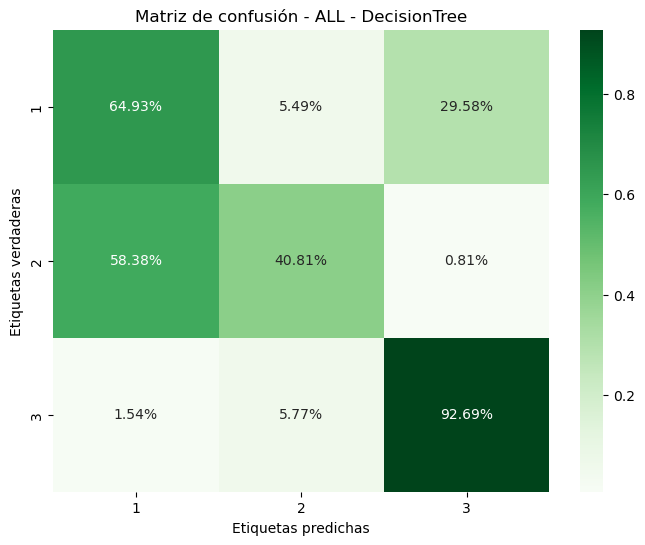

Distribución de clases en el fold: Counter({2: 36464, 1: 36335, 3: 19971})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.880714  ALL - DecisionTree (LOSO Fold)
1  Precision  0.883658  ALL - DecisionTree (LOSO Fold)
2     Recall  0.880714  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.881418  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 15}
ALL - DecisionTree - Confusion Matrix
[[2351   44  174]
 [ 165 2098  177]
 [  80  135 1273]]


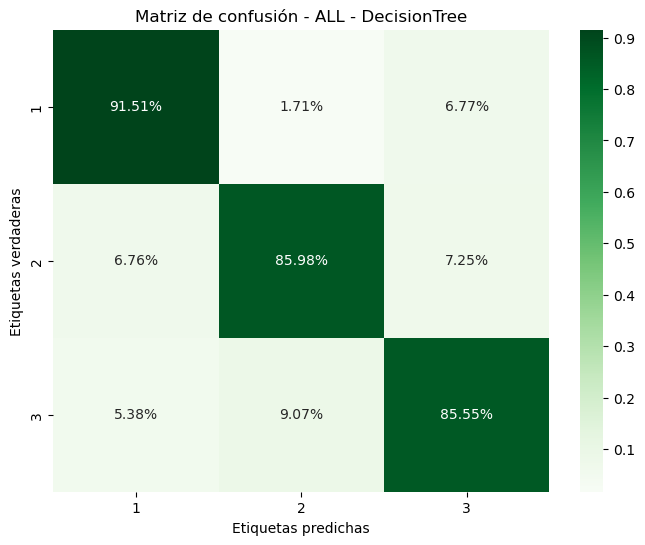

Distribución de clases en el fold: Counter({2: 36344, 1: 36293, 3: 19980})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.626165  ALL - DecisionTree (LOSO Fold)
1  Precision  0.709772  ALL - DecisionTree (LOSO Fold)
2     Recall  0.626165  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.615468  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 15, 'max_leaf_nodes': 30, 'min_samples_split': 10}
ALL - DecisionTree - Confusion Matrix
[[ 784    9 1818]
 [ 114 2411   35]
 [ 116  394  969]]


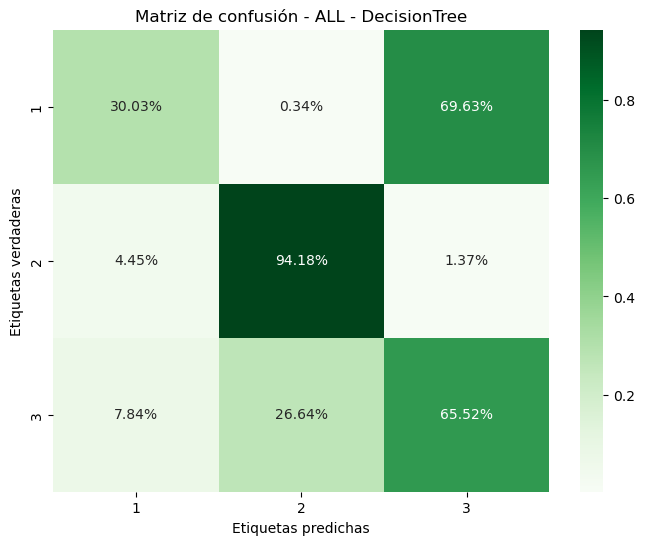

Distribución de clases en el fold: Counter({2: 36324, 1: 36261, 3: 20091})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.541648  ALL - DecisionTree (LOSO Fold)
1  Precision  0.556333  ALL - DecisionTree (LOSO Fold)
2     Recall  0.541648  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.733443  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 15, 'max_leaf_nodes': 20, 'min_samples_split': 10}
ALL - DecisionTree - Confusion Matrix
[[1320  107 1216]
 [ 330 2250    0]
 [   7 1361    0]]


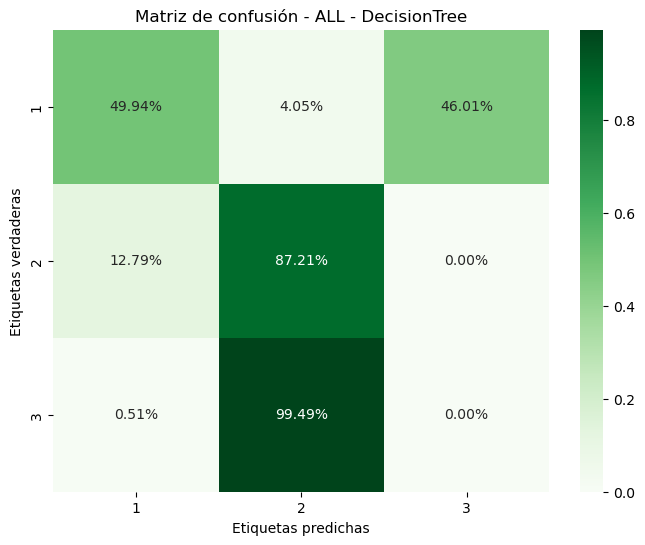

Distribución de clases en el fold: Counter({1: 36248, 2: 36124, 3: 19971})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.653524  ALL - DecisionTree (LOSO Fold)
1  Precision  0.816381  ALL - DecisionTree (LOSO Fold)
2     Recall  0.653524  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.582526  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 10, 'max_leaf_nodes': 15, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[2645    0   11]
 [2352  428    0]
 [  36    0 1452]]


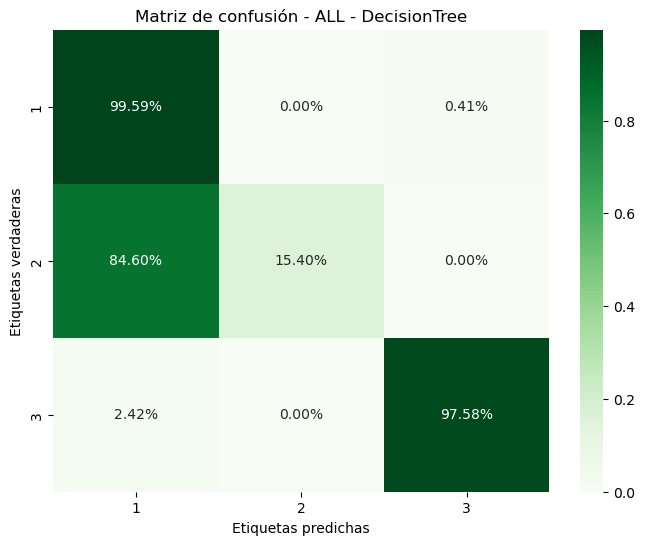

Distribución de clases en el fold: Counter({1: 36286, 2: 36184, 3: 20107})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.589836  ALL - DecisionTree (LOSO Fold)
1  Precision  0.626617  ALL - DecisionTree (LOSO Fold)
2     Recall  0.589836  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.596806  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_split': 15}
ALL - DecisionTree - Confusion Matrix
[[1684  560  374]
 [ 206 1902  612]
 [   0  992  360]]


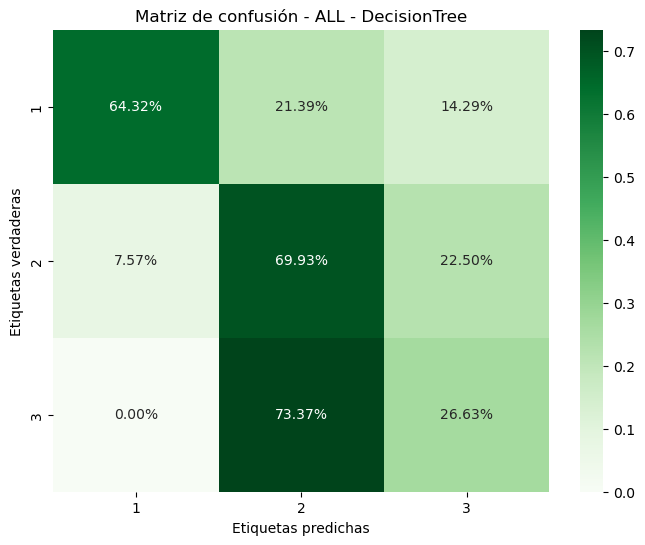

Distribución de clases en el fold: Counter({2: 36368, 1: 36351, 3: 19931})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.533626  ALL - DecisionTree (LOSO Fold)
1  Precision  0.585470  ALL - DecisionTree (LOSO Fold)
2     Recall  0.533626  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.469247  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 10, 'max_leaf_nodes': 15, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[2457    0   96]
 [1422 1054   60]
 [1508    0   20]]


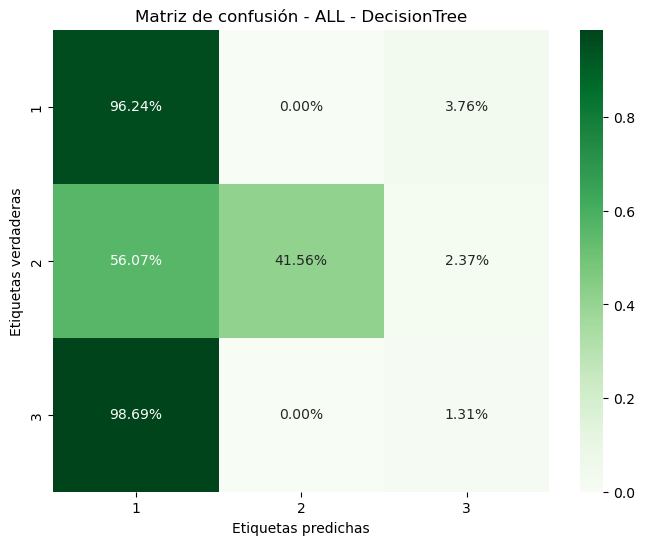

Distribución de clases en el fold: Counter({1: 36255, 2: 36204, 3: 20091})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.646122  ALL - DecisionTree (LOSO Fold)
1  Precision  0.811804  ALL - DecisionTree (LOSO Fold)
2     Recall  0.646122  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.580702  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[1640 1009    0]
 [   0 2700    0]
 [   0 1368    0]]


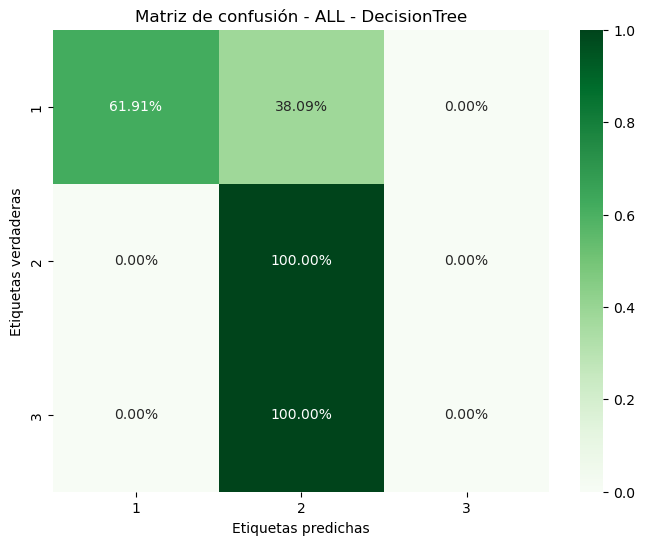

Distribución de clases en el fold: Counter({1: 36294, 2: 36280, 3: 19971})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.535257  ALL - DecisionTree (LOSO Fold)
1  Precision  0.601113  ALL - DecisionTree (LOSO Fold)
2     Recall  0.535257  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.535473  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[1280  579  751]
 [ 397 1078 1149]
 [  73  175 1240]]


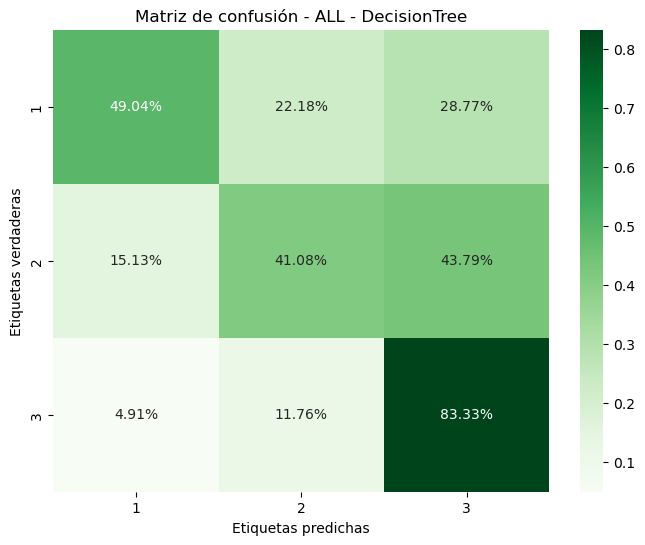

Distribución de clases en el fold: Counter({1: 36281, 2: 36212, 3: 20107})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.779361  ALL - DecisionTree (LOSO Fold)
1  Precision  0.828866  ALL - DecisionTree (LOSO Fold)
2     Recall  0.779361  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.692653  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 15, 'max_leaf_nodes': 30, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[2504  119    0]
 [   0 2692    0]
 [ 455  897    0]]


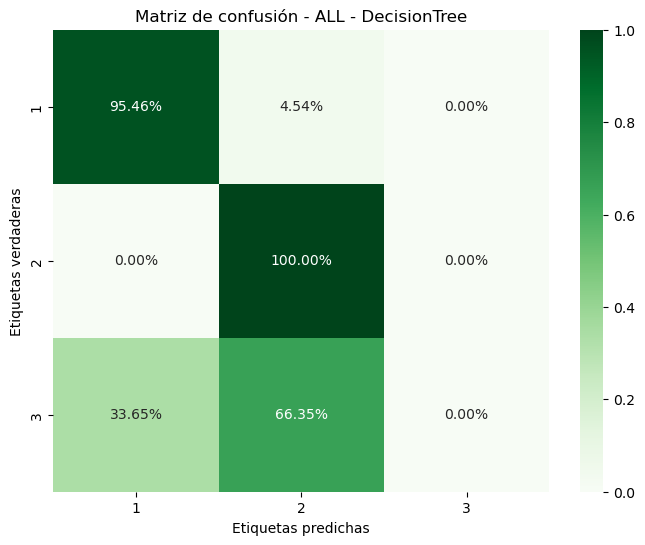

Distribución de clases en el fold: Counter({1: 36308, 2: 36132, 3: 19971})
Fitting 2 folds for each of 45 candidates, totalling 90 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.639294  ALL - DecisionTree (LOSO Fold)
1  Precision  0.540552  ALL - DecisionTree (LOSO Fold)
2     Recall  0.639294  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.802786  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 10, 'max_leaf_nodes': 15, 'min_samples_split': 10}
ALL - DecisionTree - Confusion Matrix
[[2107  465   24]
 [  15 2276  481]
 [1003  485    0]]


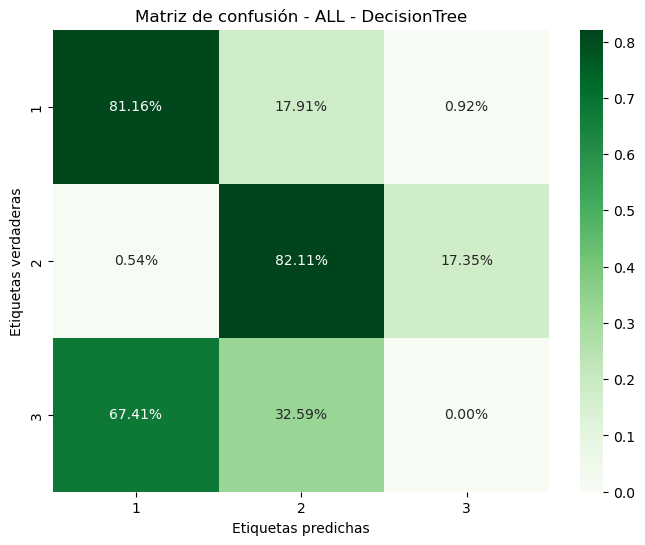

Training with ALL signals:  25%|██▌       | 1/4 [07:06<21:18, 426.09s/it]

[ALL - DecisionTree] Final Metrics:
              Valor
accuracy   0.609780
precision  0.660864
recall     0.609780
f1_score   0.637038
Training AdaBoost model for ALL signals using LOSO...
Distribución de clases en el fold: Counter({2: 36444, 1: 36356, 3: 20131})
Fitting 2 folds for each of 32 candidates, totalling 64 fits


Training with ALL signals:  25%|██▌       | 1/4 [07:27<22:21, 447.23s/it]


KeyboardInterrupt: 

In [ ]:

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    metrics = train_and_evaluate_loso(X_resampled, y_resampled, subjects_resampled, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = metrics

# Mostrar resultados finales
print("\nFinal Results:")
for (signal, model_name), metrics in results.items():
    print(f'{signal} - {model_name}:')
    for metric_name, value in metrics.items():
        print(f'  {metric_name}: {value:.4f}')

Training with ALL signals:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Distribución de clases en el fold: Counter({1: 48439, 2: 48422, 3: 37184})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.580402  ALL - DecisionTree (LOSO Fold)
1  Precision  0.466156  ALL - DecisionTree (LOSO Fold)
2     Recall  0.580402  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.771547  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
ALL - DecisionTree - Confusion Matrix
[[4711   96    0]
 [1740 3060   24]
 [3100  658    0]]


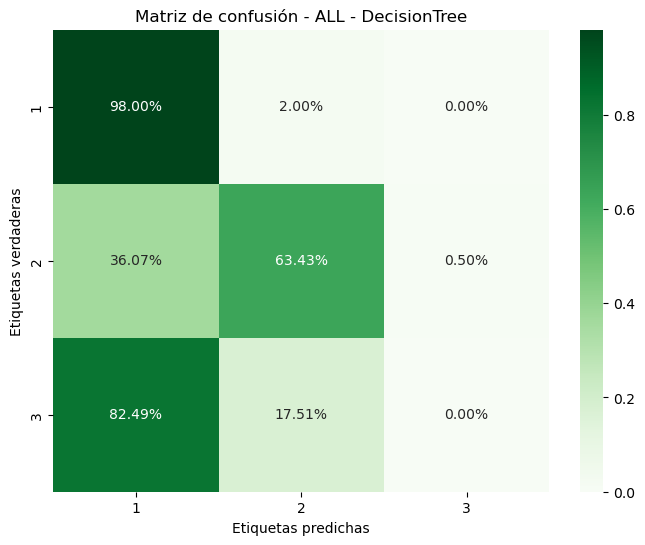

Distribución de clases en el fold: Counter({2: 48549, 1: 48454, 3: 37332})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.591572  ALL - DecisionTree (LOSO Fold)
1  Precision  0.569992  ALL - DecisionTree (LOSO Fold)
2     Recall  0.591572  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.577996  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[3930  169  693]
 [ 757 2873 1067]
 [ 604 2060  946]]


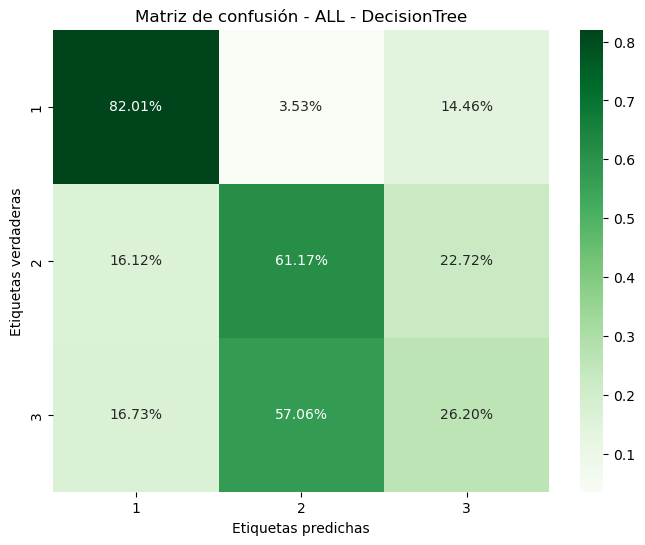

Distribución de clases en el fold: Counter({2: 48486, 1: 48452, 3: 37328})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.294806  ALL - DecisionTree (LOSO Fold)
1  Precision  0.312758  ALL - DecisionTree (LOSO Fold)
2     Recall  0.294806  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.259609  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
ALL - DecisionTree - Confusion Matrix
[[ 366  530 3898]
 [1101 1144 2515]
 [ 493  749 2372]]


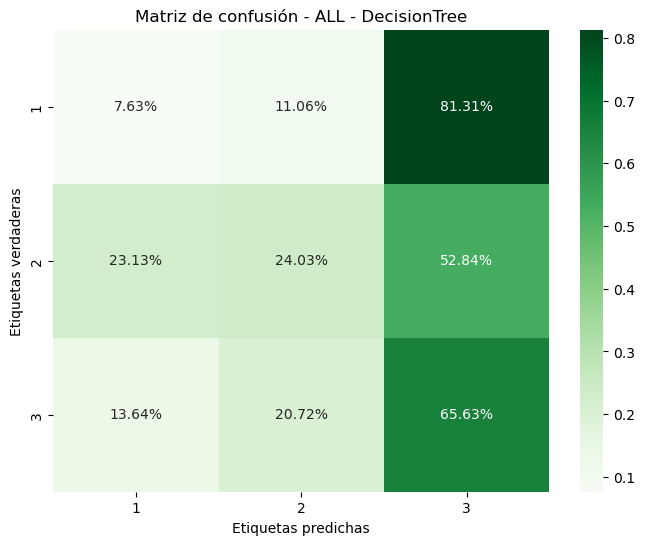

Distribución de clases en el fold: Counter({1: 48469, 2: 48418, 3: 37223})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.473131  ALL - DecisionTree (LOSO Fold)
1  Precision  0.475213  ALL - DecisionTree (LOSO Fold)
2     Recall  0.473131  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.463331  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
ALL - DecisionTree - Confusion Matrix
[[1708 1994 1075]
 [ 502 3245 1081]
 [1033 1335 1351]]


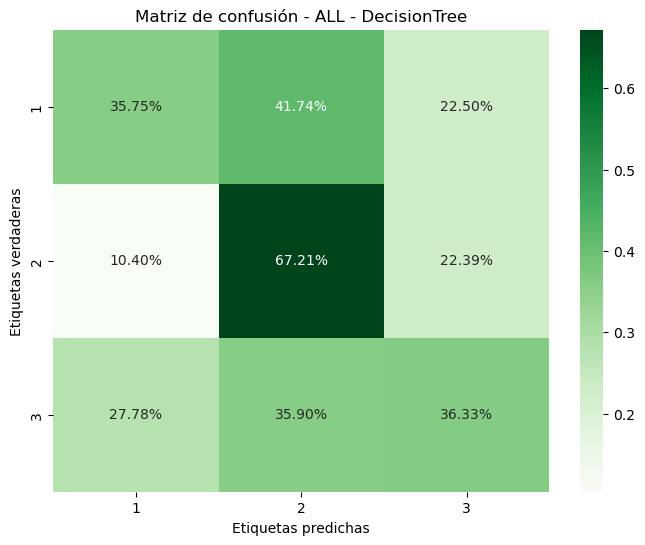

Distribución de clases en el fold: Counter({2: 49138, 1: 48477, 3: 37249})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.438902  ALL - DecisionTree (LOSO Fold)
1  Precision  0.538330  ALL - DecisionTree (LOSO Fold)
2     Recall  0.438902  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.453646  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
ALL - DecisionTree - Confusion Matrix
[[1813  573 2383]
 [ 210 2271 1627]
 [ 198 2062 1433]]


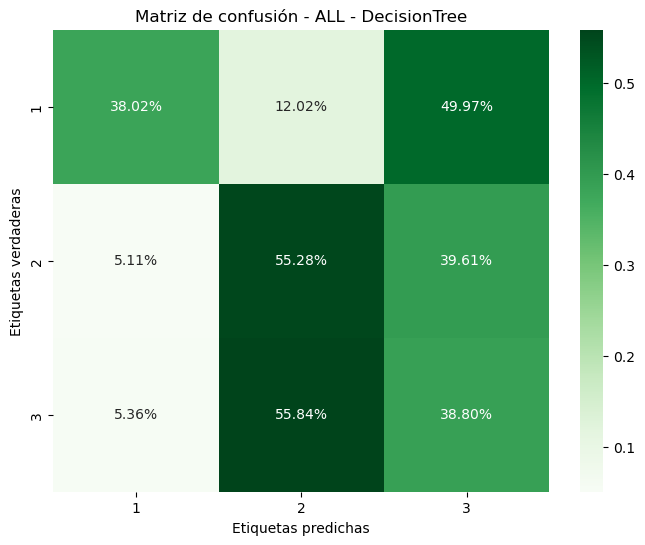

Distribución de clases en el fold: Counter({2: 48493, 1: 48396, 3: 37387})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.484724  ALL - DecisionTree (LOSO Fold)
1  Precision  0.585520  ALL - DecisionTree (LOSO Fold)
2     Recall  0.484724  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.457467  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
ALL - DecisionTree - Confusion Matrix
[[1103 2493 1254]
 [  34 3644 1075]
 [ 187 1737 1631]]


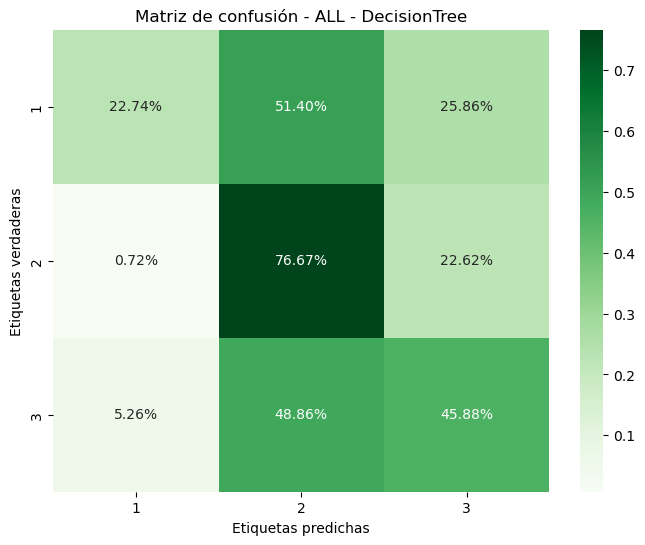

Distribución de clases en el fold: Counter({1: 48381, 2: 48265, 3: 37117})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.288567  ALL - DecisionTree (LOSO Fold)
1  Precision  0.305396  ALL - DecisionTree (LOSO Fold)
2     Recall  0.288567  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.289439  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
ALL - DecisionTree - Confusion Matrix
[[1606 1389 1870]
 [2674 1217 1090]
 [2125  578 1122]]


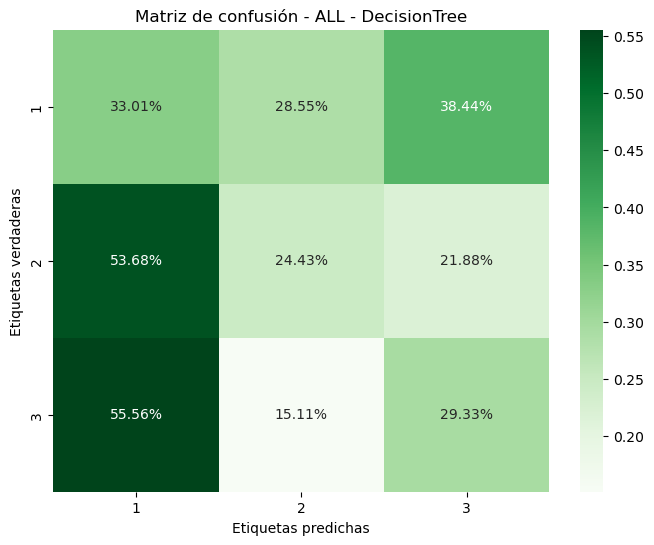

Distribución de clases en el fold: Counter({2: 48434, 1: 48424, 3: 37239})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.523656  ALL - DecisionTree (LOSO Fold)
1  Precision  0.543524  ALL - DecisionTree (LOSO Fold)
2     Recall  0.523656  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.498068  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
ALL - DecisionTree - Confusion Matrix
[[4189   45  588]
 [1770 1801 1241]
 [2015  694  994]]


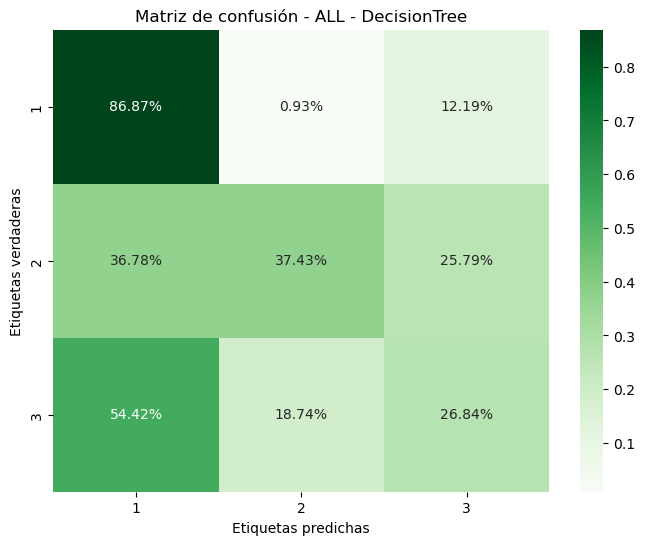

Distribución de clases en el fold: Counter({1: 48393, 2: 47644, 3: 37054})
Fitting 2 folds for each of 36 candidates, totalling 72 fits
ALL - DecisionTree (LOSO Fold) Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.564735  ALL - DecisionTree (LOSO Fold)
1  Precision  0.520944  ALL - DecisionTree (LOSO Fold)
2     Recall  0.564735  ALL - DecisionTree (LOSO Fold)
3   F1 Score  0.508486  ALL - DecisionTree (LOSO Fold)
Best params for DecisionTree in ALL: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
ALL - DecisionTree - Confusion Matrix
[[4824   21    8]
 [1820 2859  923]
 [1748 1723  417]]


In [ ]:

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    metrics = train_and_evaluate_loso(X_resampled, y_resampled, subjects_resampled, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = metrics

# Mostrar resultados finales
print("\nFinal Results:")
for (signal, model_name), metrics in results.items():
    print(f'{signal} - {model_name}:')
    for metric_name, value in metrics.items():
        print(f'  {metric_name}: {value:.4f}')